In [1]:
import sys
sys.path.append("../")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
sns.set_context('paper')
import logging
logging.basicConfig(format='%(asctime)s %(levelname)-7s %(message)s',
                    stream=sys.stderr, level=logging.INFO)
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.INFO)

import os

from pathlib import Path
import pandas as pd
import json

#In-house Module Imports
from config import Configuration 

In [4]:
user = "aksar"
logging.warning(f'Are you sure that you are: {user}?')

2022-05-20 14:02:41,029 WARNING Are you sure that you are: aksar?


In [5]:
#Update these

PARENT_DIR = 'unseen_experiments'
SYSTEM = 'volta'
EXP_NAME = 'tpds_experiments'
DIR_NAME_TO_GENERATE_RESULTS = 'experiment_1' #rf_tuncer_worst_case

In [6]:
OUTPUT_DIR = f'/projectnb/peaclab-mon/{user}/{PARENT_DIR}' # or feature_extraction_experiments
CV_INDEX = 0
SCALER = 'None' #For now, do the scaling inside the notebook, then you can move that to the class function

In [7]:
conf = Configuration(ipython=True,
                     overrides={
                         'output_dir': Path(OUTPUT_DIR), #change
                         'system' : SYSTEM,
                         'exp_name':EXP_NAME,                                                  
                         'cv_fold':CV_INDEX, 
                         'model_config': DIR_NAME_TO_GENERATE_RESULTS
                     })

with open(str(conf['experiment_dir']) + '/anom_dict.json') as f:
    ANOM_DICT = json.load(f)
with open(str(conf['experiment_dir']) + '/app_dict.json') as f:
    APP_DICT = json.load(f)    
    
APP_REVERSE_DICT = {}
for app_name, app_encoding in APP_DICT.items():
    APP_REVERSE_DICT[app_encoding] = app_name    

ANOM_REVERSE_DICT = {}
for anom_name, anom_encoding in ANOM_DICT.items():
    ANOM_REVERSE_DICT[anom_encoding] = anom_name  

2022-05-20 14:02:41,090 WARNING You set windowing False, but you are trying to define window_size parameter, it is automatically set to 0. Please double check.
2022-05-20 14:02:41,092 INFO    Setting directory names
2022-05-20 14:02:41,098 INFO    Model config folder already exists, be careful, otherwise it will overwrite!
2022-05-20 14:02:41,103 INFO    Saving configuration as CSV


# The configuration used for this run:
# {'cv_fold': 0,
#  'exp_name': 'tpds_experiments',
#  'experiment_dir': PosixPath('/projectnb/peaclab-mon/aksar/unseen_experiments/volta/tpds_experiments'),
#  'feature_extract': False,
#  'feature_select': False,
#  'hdf_data_path': PosixPath('/projectnb/peaclab-mon/aksar/datasets/tpds_data_hdfs'),
#  'metadata_path': None,
#  'model_config': 'experiment_1',
#  'model_config_dir': PosixPath('/projectnb/peaclab-mon/aksar/unseen_experiments/volta/tpds_experiments/CV_0/experiment_1'),
#  'model_dir': PosixPath('/projectnb/peaclab-mon/aksar/unseen_experiments/volta/tpds_experiments/CV_0/experiment_1/model'),
#  'num_split': 5,
#  'operation': 'read',
#  'output_dir': PosixPath('/projectnb/peaclab-mon/aksar/unseen_experiments/volta'),
#  'plots_dir': PosixPath('/projectnb/peaclab-mon/aksar/unseen_experiments/volta/tpds_experiments/CV_0/experiment_1/model/plots'),
#  'processed_ldms_data_path': None,
#  'raw_ldms_data_path': None,
#  'results_dir': Po

In [8]:
result_list = []
result_df = pd.DataFrame()

result_anom_list = []
result_anom_df = pd.DataFrame()

result_rate_list = []
result_rate_df = pd.DataFrame()

read_prefix_names = set()

for cv_index in [0]:

    conf = Configuration(ipython=True,
                         overrides={
                             'output_dir': Path(OUTPUT_DIR), #change
                             'system' : SYSTEM,
                             'exp_name':EXP_NAME,                                                  
                             'cv_fold':cv_index, 
                             'model_config': DIR_NAME_TO_GENERATE_RESULTS
                         })

    for filename in os.listdir(conf['results_dir']):
        
        prefix_filename = "#".join(filename.split("#")[:-1])
        
        if not prefix_filename in read_prefix_names:
            
            read_prefix_names.add(prefix_filename)

            filename = filename.split('.')[0]
            splitted_filename = filename.split('#')
            train_apps = splitted_filename[0].split(':')[1]
            test_apps = splitted_filename[1].split(':')[1]
            num_unknown_test_apps = len(test_apps.split("-"))
            num_known_train_apps = len(train_apps.split("-"))
            model_name = splitted_filename[2].split(':')[1]
            cv_fold = splitted_filename[3].split(':')[1]     
            
            result_row = {
                "train_apps": train_apps,
                "test_apps": test_apps,
                "num_unknown_test_apps": int(num_unknown_test_apps),
                "num_known_train_apps": int(num_known_train_apps),
                "model_name": model_name,
                "cv_fold": cv_fold
            }

            with open(Path(conf['results_dir']) / (prefix_filename + "#result_dict.json"), 'r') as f:

                result_json = json.load(f)  

                result_row['macro_f1_score'] = result_json['macro avg']['f1-score']
                result_row['weighted_f1_score'] = result_json['weighted avg']['f1-score']
                
                result_list.append(result_row)
                #result_df = result_df.append(result_row, ignore_index=True)
                
                for anom_name in list(ANOM_DICT.keys()):
                    for score_name in ['f1-score','precision','recall']:
                        result_anom_row = {
                                "train_apps": train_apps,
                                "test_apps": test_apps,
                                "num_unknown_test_apps": int(num_unknown_test_apps),
                                "num_known_train_apps": int(num_known_train_apps),
                                "anom_name" : anom_name,
                                "score_name" : score_name,
                                "score" :result_json[anom_name][score_name],
                                "cv_fold": cv_fold
                        }     
                        result_anom_list.append(result_anom_row)                       
                        #result_anom_df = result_anom_df.append(result_anom_row, ignore_index=True)                       

            with open(Path(conf['results_dir']) / (prefix_filename + "#alert_dict.json"), 'r') as f:

                alert_json = json.load(f)  
                                
                for rate_name in ["false_alarm_rate","anom_miss_rate"]:
                    
                    result_rate_row = {
                            "train_apps": train_apps,
                            "test_apps": test_apps,
                            "num_unknown_test_apps": int(num_unknown_test_apps),
                            "num_known_train_apps": int(num_known_train_apps),
                            "score_name" : rate_name,
                            "score" :alert_json[rate_name],
                            "cv_fold": cv_fold
                    }
                    result_rate_list.append(result_rate_row)
                    #result_rate_df = result_rate_df.append(result_rate_row, ignore_index=True)

                    
result_df = pd.DataFrame.from_dict(result_list)
result_rate_df = pd.DataFrame.from_dict(result_rate_list)
result_anom_df = pd.DataFrame.from_dict(result_anom_list)

2022-05-20 14:02:41,145 WARNING You set windowing False, but you are trying to define window_size parameter, it is automatically set to 0. Please double check.
2022-05-20 14:02:41,146 INFO    Setting directory names
2022-05-20 14:02:41,147 INFO    Model config folder already exists, be careful, otherwise it will overwrite!
2022-05-20 14:02:41,148 INFO    Saving configuration as CSV


# The configuration used for this run:
# {'cv_fold': 0,
#  'exp_name': 'tpds_experiments',
#  'experiment_dir': PosixPath('/projectnb/peaclab-mon/aksar/unseen_experiments/volta/tpds_experiments'),
#  'feature_extract': False,
#  'feature_select': False,
#  'hdf_data_path': PosixPath('/projectnb/peaclab-mon/aksar/datasets/tpds_data_hdfs'),
#  'metadata_path': None,
#  'model_config': 'experiment_1',
#  'model_config_dir': PosixPath('/projectnb/peaclab-mon/aksar/unseen_experiments/volta/tpds_experiments/CV_0/experiment_1'),
#  'model_dir': PosixPath('/projectnb/peaclab-mon/aksar/unseen_experiments/volta/tpds_experiments/CV_0/experiment_1/model'),
#  'num_split': 5,
#  'operation': 'read',
#  'output_dir': PosixPath('/projectnb/peaclab-mon/aksar/unseen_experiments/volta'),
#  'plots_dir': PosixPath('/projectnb/peaclab-mon/aksar/unseen_experiments/volta/tpds_experiments/CV_0/experiment_1/model/plots'),
#  'processed_ldms_data_path': None,
#  'raw_ldms_data_path': None,
#  'results_dir': Po

In [9]:
unique_test_app_combos = result_df['test_apps'].unique()

if SYSTEM == 'volta':
    all_apps = ['kripke','miniMD','lu','miniAMR','sp','ft','bt','cg','miniGhost','mg','CoMD']
    
elif SYSTEM == 'eclipse':
    all_apps = ['LAMMPS','sw4lite', 'examiniMD', 'swfft', 'HACC', 'sw4']

## Sort the Best and Worst 2 Train App Combinations

In [10]:
analyze_top_results = result_df[result_df['num_known_train_apps'] == 2].sort_values(by=['macro_f1_score'])
analyze_top_results.head()

,cv_fold,macro_f1_score,model_name,num_known_train_apps,num_unknown_test_apps,test_apps,train_apps,weighted_f1_score
4278,0,0.232934,RandomForestClassifier,2,3,ft-miniAMR-bt,CoMD-miniGhost,0.026015
5424,0,0.234839,RandomForestClassifier,2,3,cg-miniAMR-bt,CoMD-miniGhost,0.026754
190,0,0.234881,RandomForestClassifier,2,3,ft-miniAMR-sp,CoMD-miniGhost,0.026711
4811,0,0.235117,RandomForestClassifier,2,3,cg-miniAMR-sp,CoMD-miniGhost,0.027279
2283,0,0.235162,RandomForestClassifier,2,3,ft-miniAMR-miniMD,CoMD-miniGhost,0.026827


In [11]:
worst_and_best_combos = pd.concat([analyze_top_results.iloc[0:100],analyze_top_results.iloc[-100:]])

In [12]:
worst_and_best_combos.to_csv("/projectnb/peaclab-mon/aksar/active_learning_experiments/volta/mvts_experiments/worst_best_app_combos.csv",index=False)

## Analyze the outlier cases

In [13]:
param_dict = {
                'fig_width': 18,
                'fig_height': 12,
                'y_label_font': 45,
                'x_label_font': 45,
                 'x_ticks_font': 42,
                 'y_ticks_font': 50,    
                'legend_size': 26,
                'legend_title_size': 55,
                'title_size': 36,
                'title_pad': 40,             
             }

In [14]:
result_df['num_known_train_apps'] = result_df['num_known_train_apps'].astype('int')

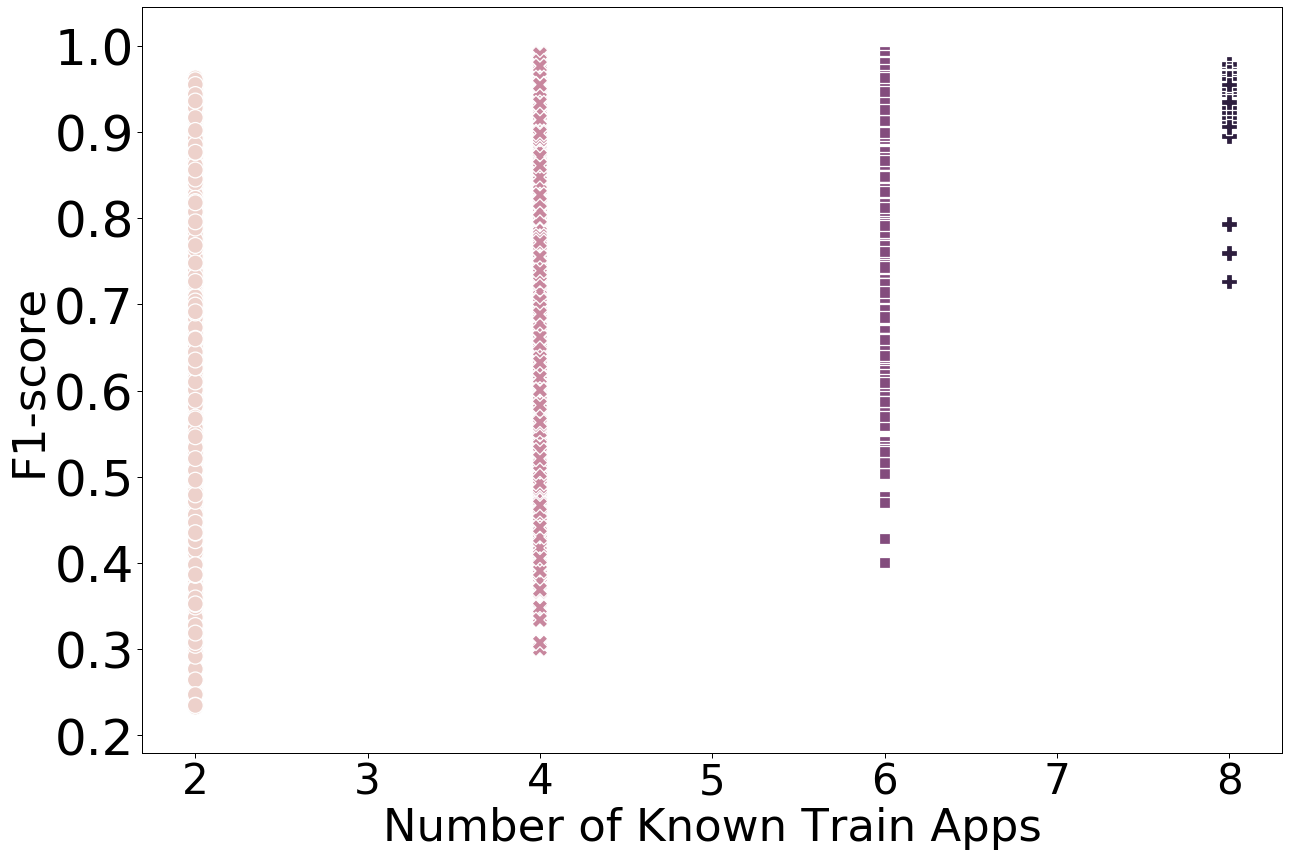

In [15]:
fig = plt.figure(figsize=(param_dict['fig_width'], param_dict['fig_height']))
ax = sns.scatterplot(data=result_df, x="num_known_train_apps", y="macro_f1_score", 
                     hue="num_known_train_apps",
                     style="num_known_train_apps",
                     s=250
                    )

ax.set_ylabel('F1-score',size=param_dict['y_label_font'])
ax.set_xlabel("Number of Known Train Apps",size=param_dict['x_label_font'])

ax.get_legend().remove()

plt.xticks(fontsize=param_dict['x_ticks_font'])
plt.yticks(fontsize=param_dict['y_ticks_font'])

plt.tight_layout()   

2022-05-20 14:02:53,264 INFO    Note: NumExpr detected 28 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.


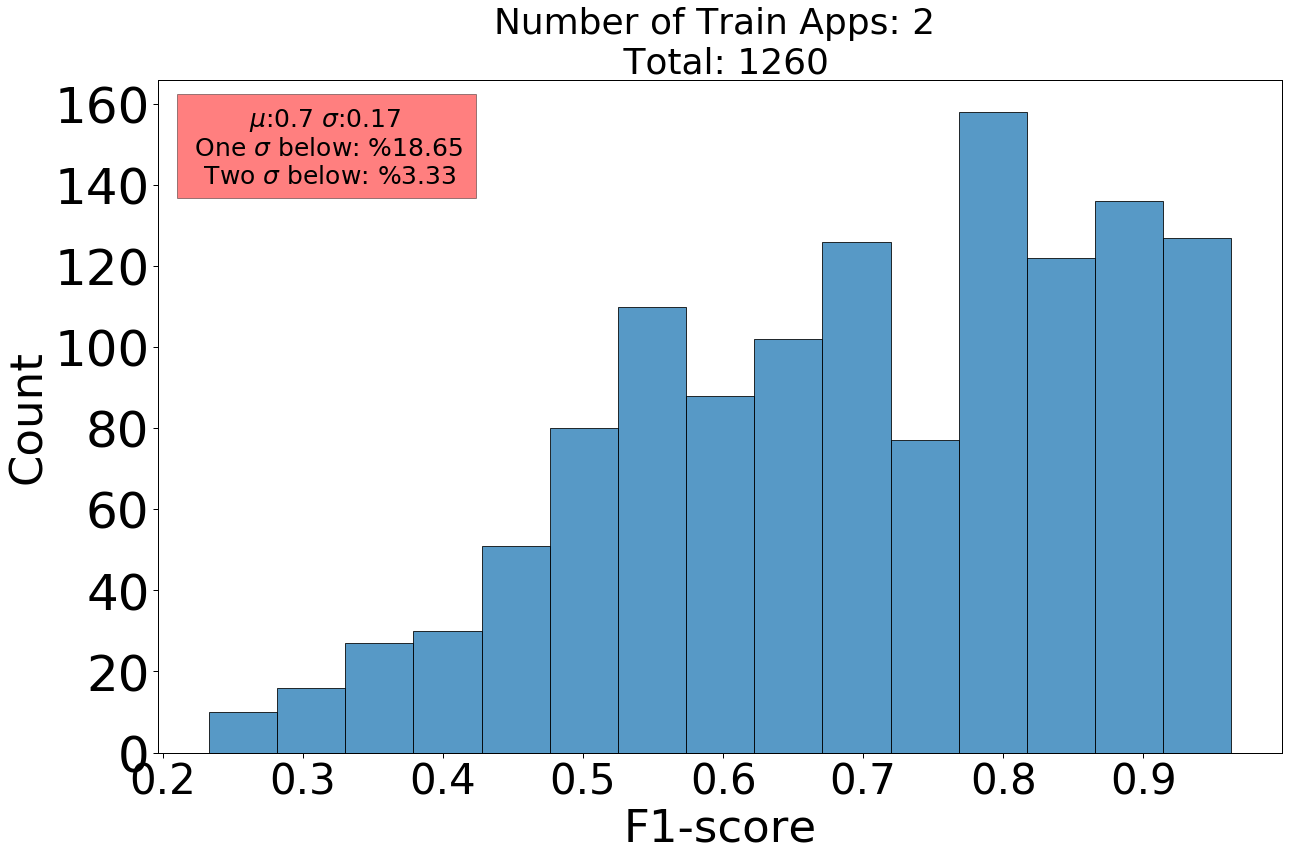

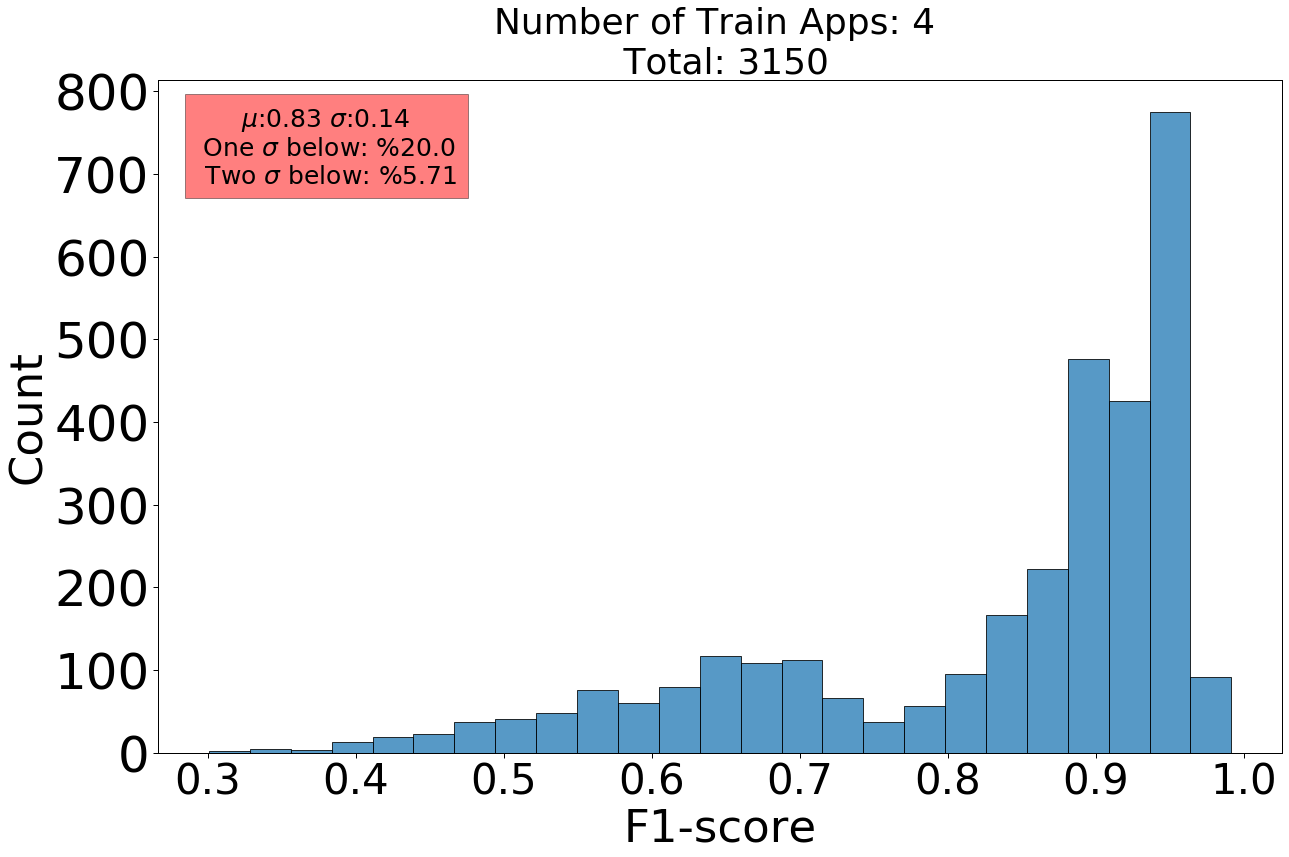

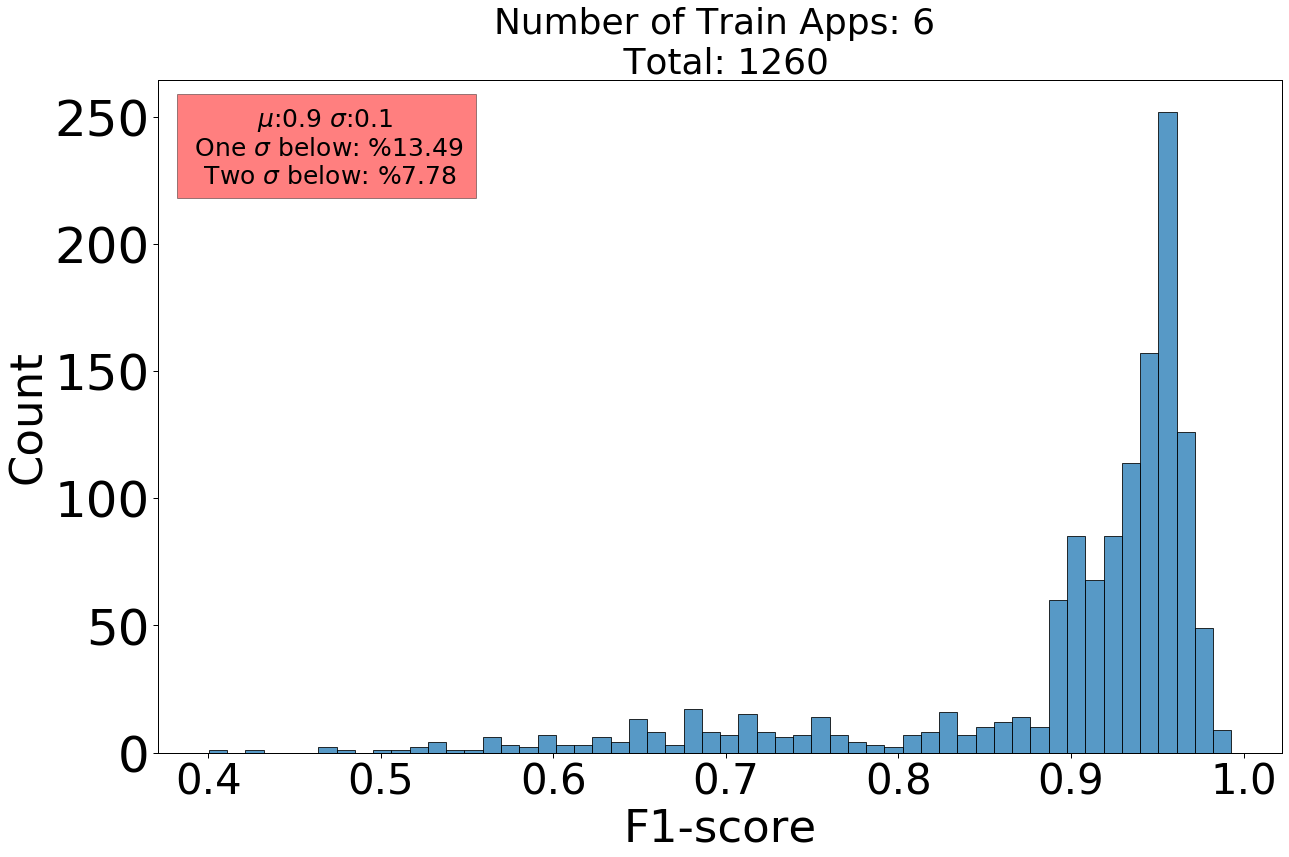

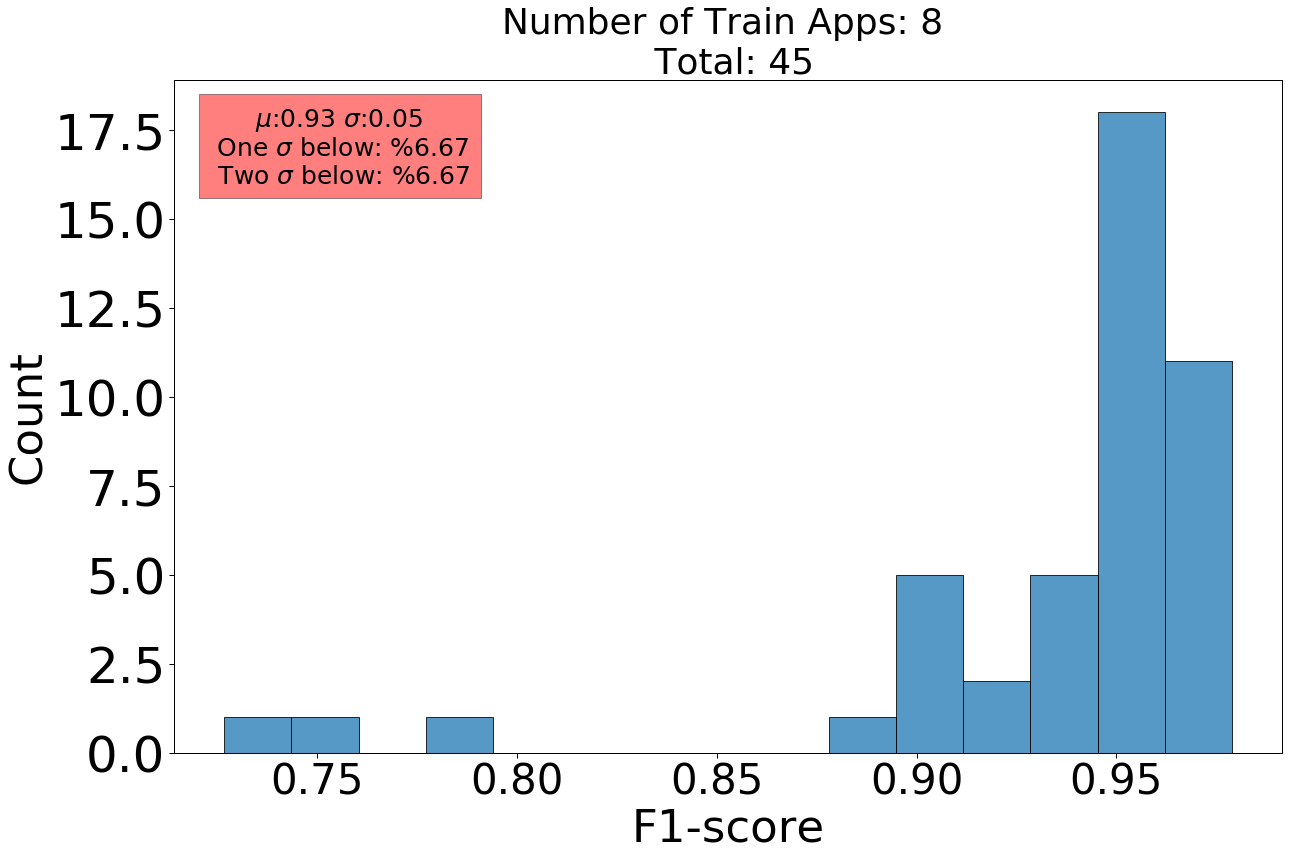

In [16]:
for num_known_train_apps in sorted(result_df['num_known_train_apps'].unique()):
    
    temp_score_df = result_df[result_df['num_known_train_apps'] == num_known_train_apps].sort_values(by=['macro_f1_score'])
    fig = plt.figure(figsize=(param_dict['fig_width'], param_dict['fig_height']))
    temp_total = len(temp_score_df)
    
    temp_mean = temp_score_df['macro_f1_score'].mean()
    temp_std = temp_score_df['macro_f1_score'].std()
    two_std_below = temp_mean - 2*temp_std
    one_std_below = temp_mean - temp_std    
    one_std_below_vals = len(temp_score_df['macro_f1_score'].values[temp_score_df['macro_f1_score'].values < one_std_below])
    two_std_below_vals = len(temp_score_df['macro_f1_score'].values[temp_score_df['macro_f1_score'].values < two_std_below])    

    ax = sns.histplot(data=temp_score_df, x="macro_f1_score")    
    
    ax.text(0.15, 0.9,f'$\mu$:{np.round(temp_mean,2)} $\sigma$:{np.round(temp_std,2)} \n One $\sigma$ below: %{np.round(100*(one_std_below_vals/temp_total),2)} \n Two $\sigma$ below: %{np.round(100*(two_std_below_vals/temp_total),2)}', 
            bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10},
            fontsize=25,
            ha='center', va='center', transform=ax.transAxes)    

    ax.set_ylabel('Count',size=param_dict['y_label_font'])
    ax.set_xlabel("F1-score",size=param_dict['x_label_font'])
    ax.set_title(f"Number of Train Apps: {int(num_known_train_apps)} \n Total: {temp_total}",size=param_dict['title_size'])

    plt.xticks(fontsize=param_dict['x_ticks_font'])
    plt.yticks(fontsize=param_dict['y_ticks_font'])

    plt.tight_layout()    

## Plot Average Scores for Experiments

In [17]:
min_f1_scores = result_df.groupby(['num_known_train_apps']).min()['macro_f1_score'].values
print("Min F1 Scores \n", min_f1_scores)

min_f1_scores_train_apps = result_df.groupby(['num_known_train_apps']).min()['train_apps'].values
print("Min F1 Scores Train Apps \n", min_f1_scores_train_apps)
min_f1_scores_test_apps = result_df.groupby(['num_known_train_apps']).min()['test_apps'].values
print("Min F1 Scores Test Apps \n", min_f1_scores_test_apps)


max_f1_scores = result_df.groupby(['num_known_train_apps']).max()['macro_f1_score'].values
print("Max F1 Scores \n", max_f1_scores)

max_f1_scores_train_apps = result_df.groupby(['num_known_train_apps']).max()['train_apps'].values
print("Max F1 Scores Train Apps \n", max_f1_scores_train_apps)
max_f1_scores_test_apps = result_df.groupby(['num_known_train_apps']).max()['test_apps'].values
print("Max F1 Scores Test Apps \n", max_f1_scores_test_apps)


max_f1_scores_apps = result_df.groupby(['num_known_train_apps']).max()['train_apps'].values
print("Min F1 Scores Apps \n", max_f1_scores_apps)


std_f1_scores = result_df.groupby(['num_known_train_apps']).std()['macro_f1_score'].values
print("Std F1 Scores \n", std_f1_scores)

Min F1 Scores 
 [0.23293415 0.30064506 0.40037088 0.72669055]
Min F1 Scores Train Apps 
 ['CoMD-bt' 'CoMD-bt-cg-ft' 'CoMD-bt-cg-ft-lu-miniGhost'
 'CoMD-bt-cg-sp-miniMD-ft-lu-miniGhost']
Min F1 Scores Test Apps 
 ['cg-lu-CoMD' 'cg-lu-CoMD' 'cg-lu-CoMD' 'cg-lu-CoMD']
Max F1 Scores 
 [0.96285435 0.99173241 0.99293265 0.9789552 ]
Max F1 Scores Train Apps 
 ['sp-miniMD' 'sp-miniMD-miniAMR-miniGhost'
 'sp-miniMD-miniAMR-ft-miniGhost-mg'
 'miniMD-CoMD-miniGhost-miniAMR-sp-cg-kripke-mg']
Max F1 Scores Test Apps 
 ['mg-miniGhost-sp' 'mg-miniGhost-sp' 'mg-miniGhost-sp' 'mg-miniGhost-sp']
Min F1 Scores Apps 
 ['sp-miniMD' 'sp-miniMD-miniAMR-miniGhost'
 'sp-miniMD-miniAMR-ft-miniGhost-mg'
 'miniMD-CoMD-miniGhost-miniAMR-sp-cg-kripke-mg']
Std F1 Scores 
 [0.17035639 0.14343837 0.0994701  0.05229483]


In [18]:
grouped_rate_df = result_rate_df.groupby(['num_known_train_apps','score_name']).max()
far_df = grouped_rate_df.loc[(slice(None), 'false_alarm_rate'), :]
amr_df = grouped_rate_df.loc[(slice(None), 'anom_miss_rate'), :]

In [19]:
far_df

,,cv_fold,num_unknown_test_apps,score,test_apps,train_apps
num_known_train_apps,score_name,,,,,
2,false_alarm_rate,0,3,1.000000,mg-miniGhost-sp,sp-miniMD
4,false_alarm_rate,0,3,0.985921,mg-miniGhost-sp,sp-miniMD-miniAMR-miniGhost
6,false_alarm_rate,0,3,0.890453,mg-miniGhost-sp,sp-miniMD-miniAMR-ft-miniGhost-mg
8,false_alarm_rate,0,3,0.311111,mg-miniGhost-sp,miniMD-CoMD-miniGhost-miniAMR-sp-cg-kripke-mg


In [20]:
amr_df

,,cv_fold,num_unknown_test_apps,score,test_apps,train_apps
num_known_train_apps,score_name,,,,,
2,anom_miss_rate,0,3,0.344231,mg-miniGhost-sp,sp-miniMD
4,anom_miss_rate,0,3,0.338462,mg-miniGhost-sp,sp-miniMD-miniAMR-miniGhost
6,anom_miss_rate,0,3,0.178846,mg-miniGhost-sp,sp-miniMD-miniAMR-ft-miniGhost-mg
8,anom_miss_rate,0,3,0.167619,mg-miniGhost-sp,miniMD-CoMD-miniGhost-miniAMR-sp-cg-kripke-mg


In [21]:
param_dict = {
                'fig_width': 28,
                'fig_height': 12,
                'y_label_font': 42,
                'x_label_font': 42,
                'x_ticks_font': 32,
                'y_ticks_font': 36,    
                'legend_size': 30,
                'legend_title_size': 40,
                'title_size': 45,
                'title_pad': 40,
                'suptitle_font': 25,
                'suptitle_y': 1.1,
             }

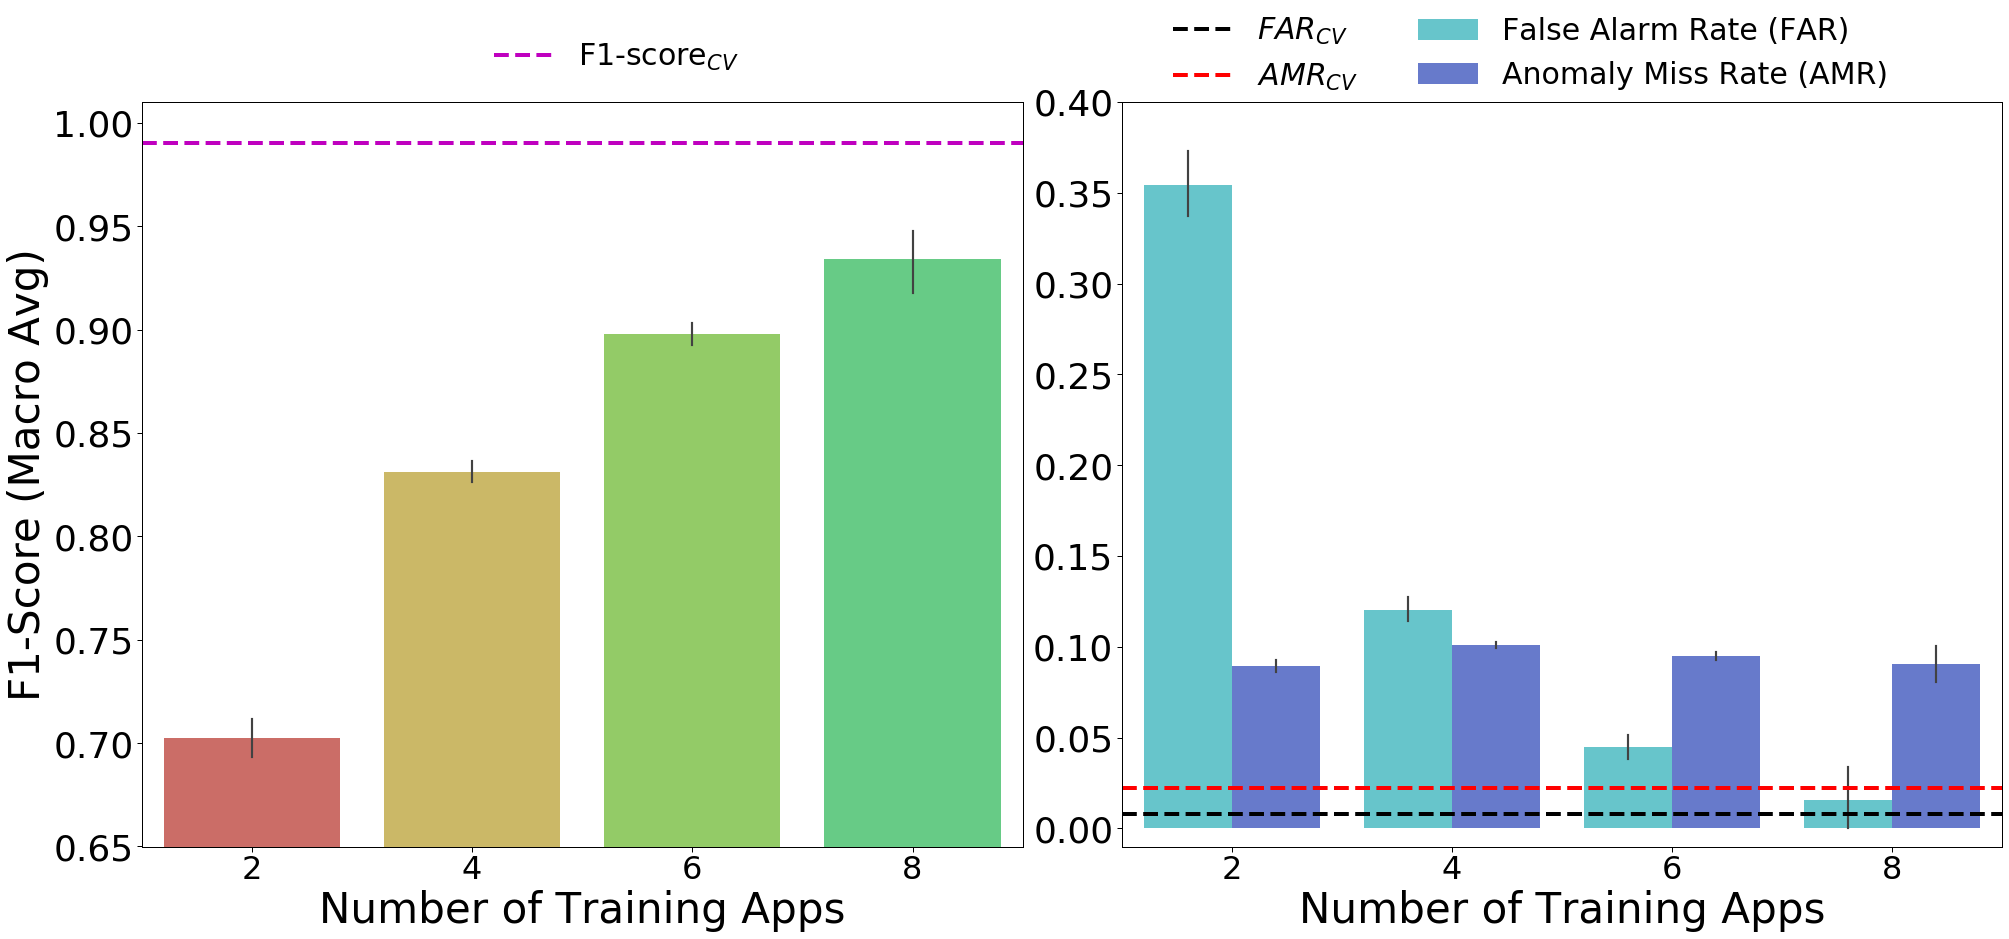

In [57]:
fig, axs = plt.subplots(1,2,figsize=(param_dict['fig_width'], param_dict['fig_height']))

sns.barplot(
            x="num_known_train_apps", 
            y="macro_f1_score", 
            ax=axs[0],
            palette=sns.color_palette("hls", 8)[:4],
            data=result_df) 

#fig.suptitle(f"{int(result_df['num_unknown_test_apps'].unique()[0])} Unknowns in the Test Set",size=param_dict['suptitle_font'], y=param_dict['suptitle_y'])
#fig.suptitle(f"Supervised Models",size=param_dict['suptitle_font'], y=param_dict['suptitle_y'])
fig.suptitle("")

axs[0].set_ylabel('F1-Score (Macro Avg)', size=param_dict['y_label_font'])
axs[0].set_xlabel(f'Number of Training Apps',size=param_dict['x_label_font'])
axs[0].set_title(f"",size=param_dict['title_size'])

axs[0].tick_params(axis='x', labelsize= param_dict['x_ticks_font'])
axs[0].tick_params(axis='y', labelsize= param_dict['y_ticks_font'])

axs[0].axhline(y=0.99, linewidth=4, color='m', linestyle='--', label='5-CV')                 
axs[0].set_ylim(0.65,1.01)
axs[1].set_ylim(-0.01,0.4)

                 
sns.barplot(
            x="num_known_train_apps", 
            y="score", 
            hue="score_name",
            ax=axs[1],
            palette=sns.color_palette("hls", 8)[4:6],
            data=result_rate_df) 
                 
                 
axs[1].set_ylabel('', size=param_dict['y_label_font'])
axs[1].set_xlabel(f'Number of Training Apps',size=param_dict['x_label_font'])
axs[1].set_title(f"",size=param_dict['title_size'])

axs[1].tick_params(axis='x', labelsize= param_dict['x_ticks_font'])
axs[1].tick_params(axis='y', labelsize= param_dict['y_ticks_font']) 

handles_0, labels_0 = axs[0].get_legend_handles_labels()           


legend=fig.legend(
            handles_0,
            ['F1-score$_{CV}$',"False Alarm Rate","Anomaly Miss Rate","$FAR_{CV}$","$AMR_{CV}$"],
            bbox_to_anchor=(0.13, 0.62, 0.25, 0.45),
            #loc='best', 
            ncol = 1, 
            title = "",
            frameon = False,
            prop={'size': param_dict['legend_size']}, 
          )

axs[1].axhline(y=0.008, linewidth=4, color='k', linestyle='--', label="$FAR_{CV}$")  
axs[1].axhline(y=0.022, linewidth=4, color='r', linestyle='--', label="$AMR_{CV}$")                 

handles, labels = axs[1].get_legend_handles_labels()           
                          
legend=fig.legend(
            handles,
            ["$FAR_{CV}$","$AMR_{CV}$","False Alarm Rate (FAR)","Anomaly Miss Rate (AMR)"],
            bbox_to_anchor=(0.50, 0.65, 0.45, 0.45),
           #loc='best', 
            ncol = 2, 
            title = "",
            frameon = False,    
            prop={'size': param_dict['legend_size']}, 
          )

axs[1].get_legend().remove()

             
plt.tight_layout() 
plt.savefig(f"/usr3/graduate/baksar/projectx/AI4HPCAnalytics/src/unseen_experiments/plots/{SYSTEM}_unseen_motivational.pdf", bbox_inches='tight')

## Plot All Unique App Combinations in the Test Set for Experiments

In [19]:
param_dict = {
                'fig_width': 18,
                'fig_height': 12,
                'y_label_font': 45,
                'x_label_font': 45,
                 'x_ticks_font': 42,
                 'y_ticks_font': 50,    
                'legend_size': 26,
                'legend_title_size': 55,
                'title_size': 36,
                'title_pad': 40,             
             }

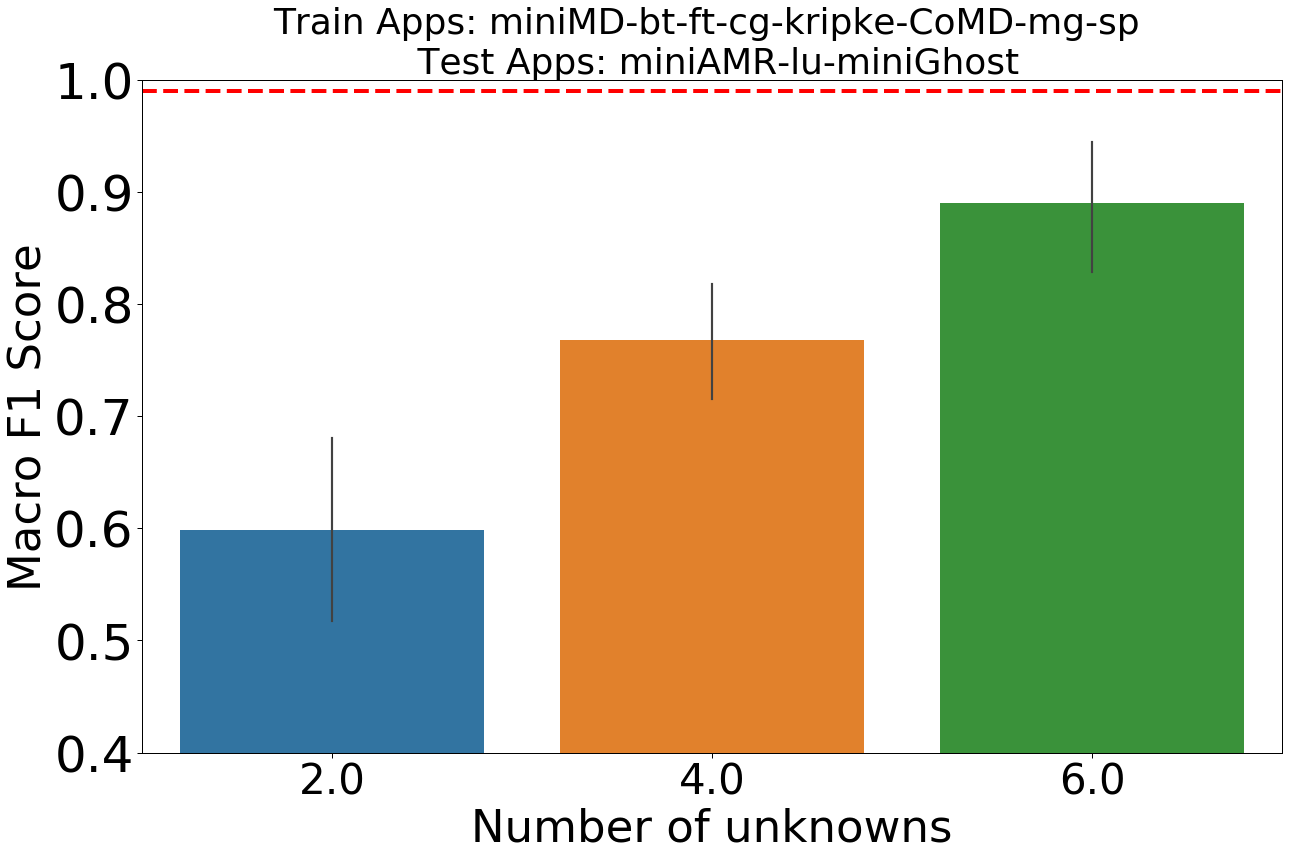

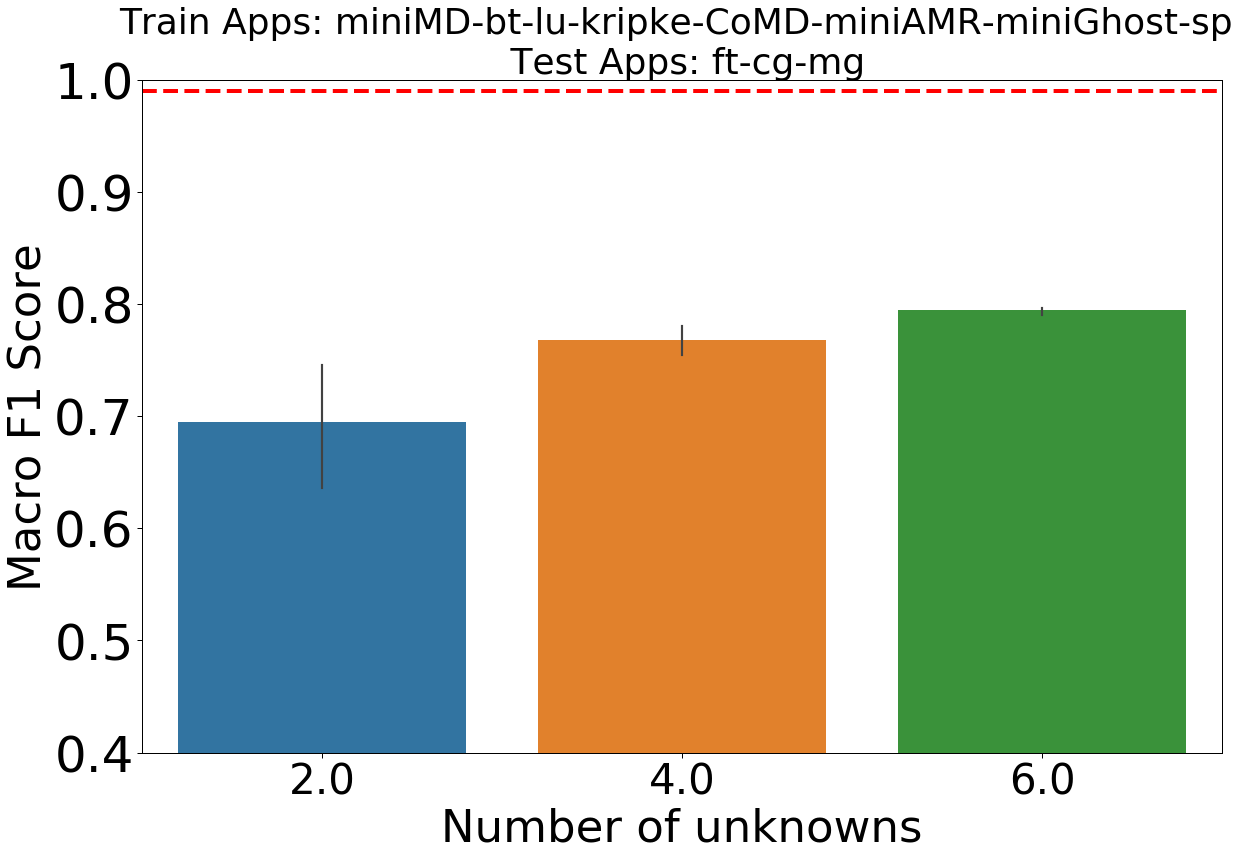

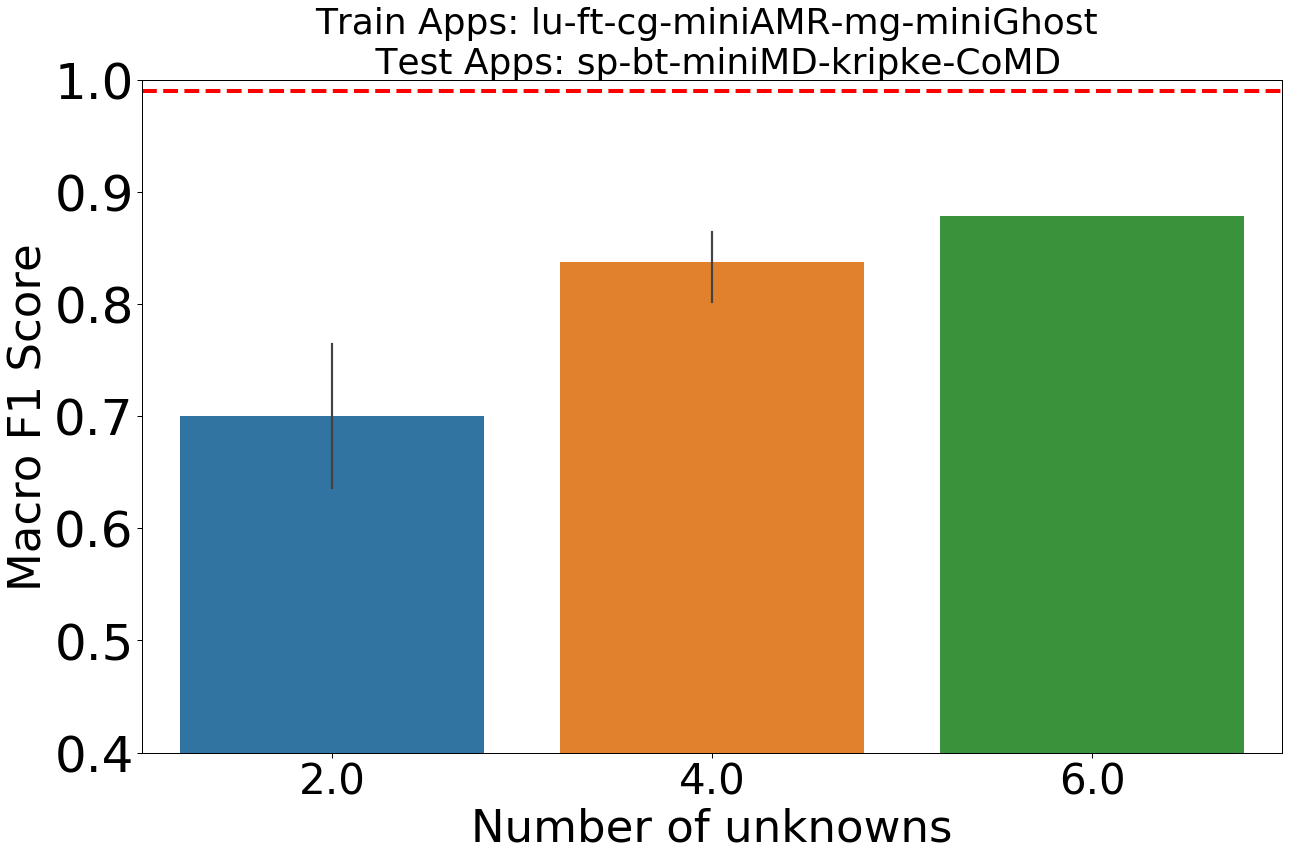

In [22]:
for app_combo in unique_test_app_combos: 
    
    temp_result_df = result_df[result_df['test_apps'] == app_combo]
    curr_train_apps = "-".join(set(all_apps) - set(app_combo.split('-')))
        
    fig = plt.figure(figsize=(param_dict['fig_width'], param_dict['fig_height']))
    ax = sns.barplot(x="num_known_train_apps", 
                     y="macro_f1_score", 
                     data=temp_result_df) 
        
    ax.set_ylabel('Macro F1 Score',size=param_dict['y_label_font'])
    ax.set_xlabel(f'Number of unknowns',size=param_dict['x_label_font'])
    ax.set_title(f"Train Apps: {curr_train_apps} \n Test Apps: {app_combo}",size=param_dict['title_size'])

    plt.xticks(fontsize=param_dict['x_ticks_font'])
    plt.yticks(fontsize=param_dict['y_ticks_font'])

    plt.axhline(y=0.99,linewidth=4, color='r', linestyle='--', label='5-CV')

    ax.set(ylim=(0.4, 1))

    plt.tight_layout()

## Plot Macro Average F1-scores According to Selected App Combos

In [40]:
param_dict = {
                'fig_width': 18,
                'fig_height': 12,
                'y_label_font': 45,
                'x_label_font': 45,
                 'x_ticks_font': 42,
                 'y_ticks_font': 50,    
                'legend_size': 26,
                'legend_title_size': 55,
                'title_size': 36,
                'title_pad': 40,             
             }

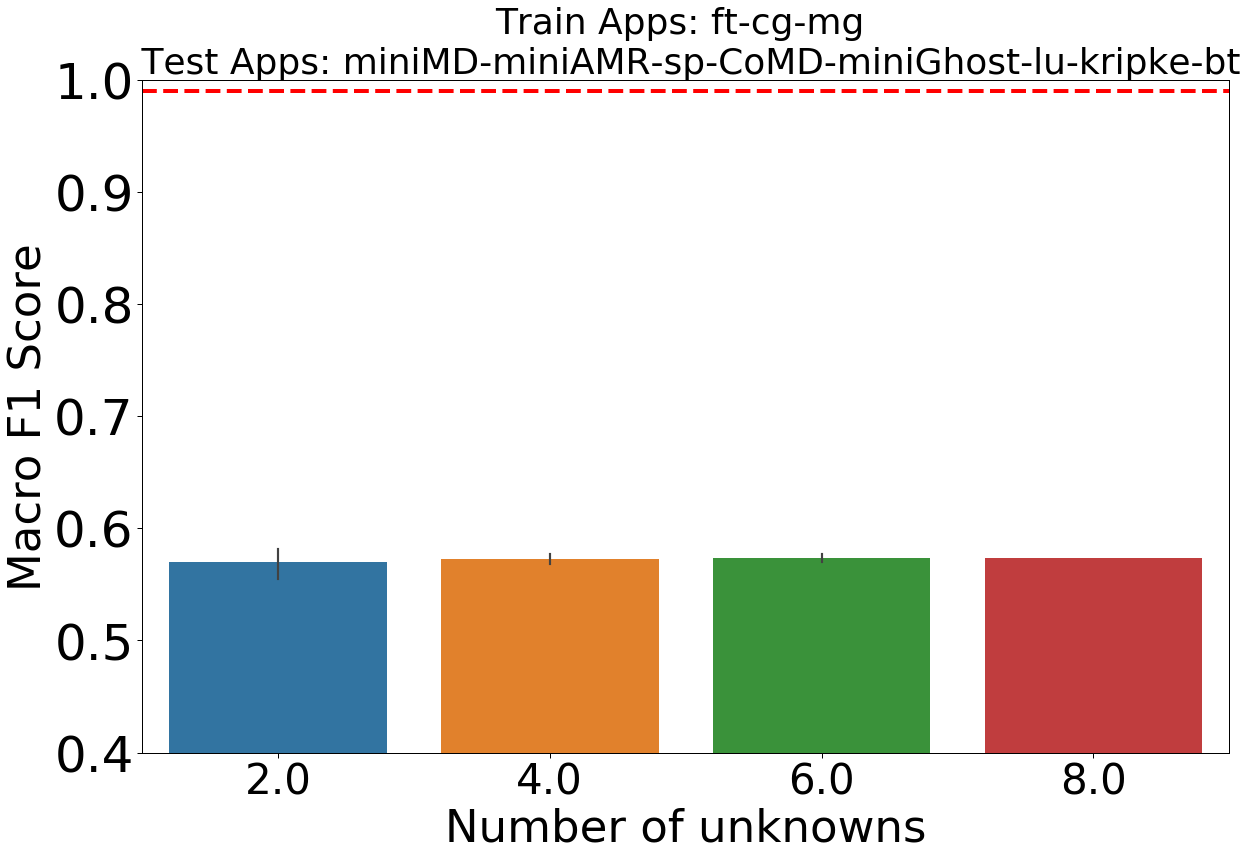

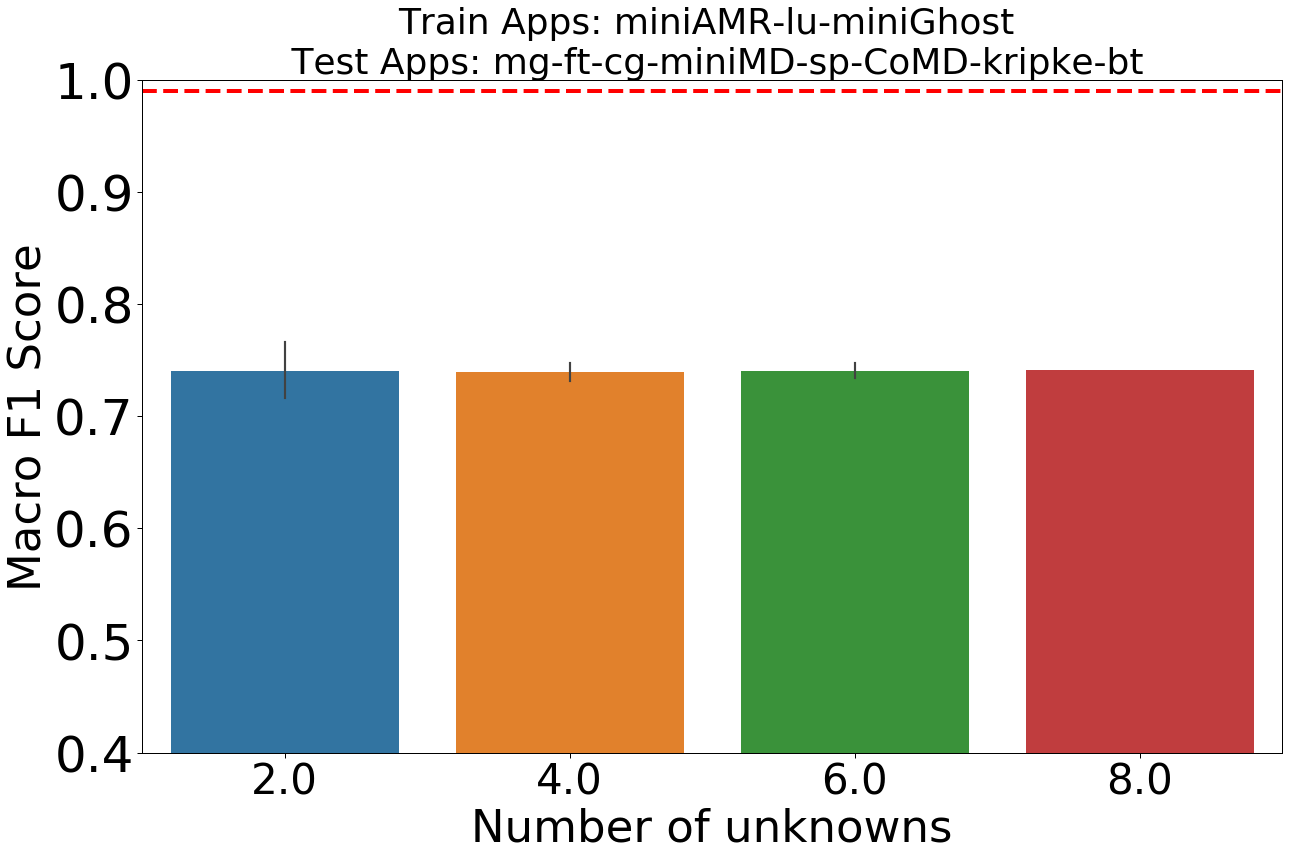

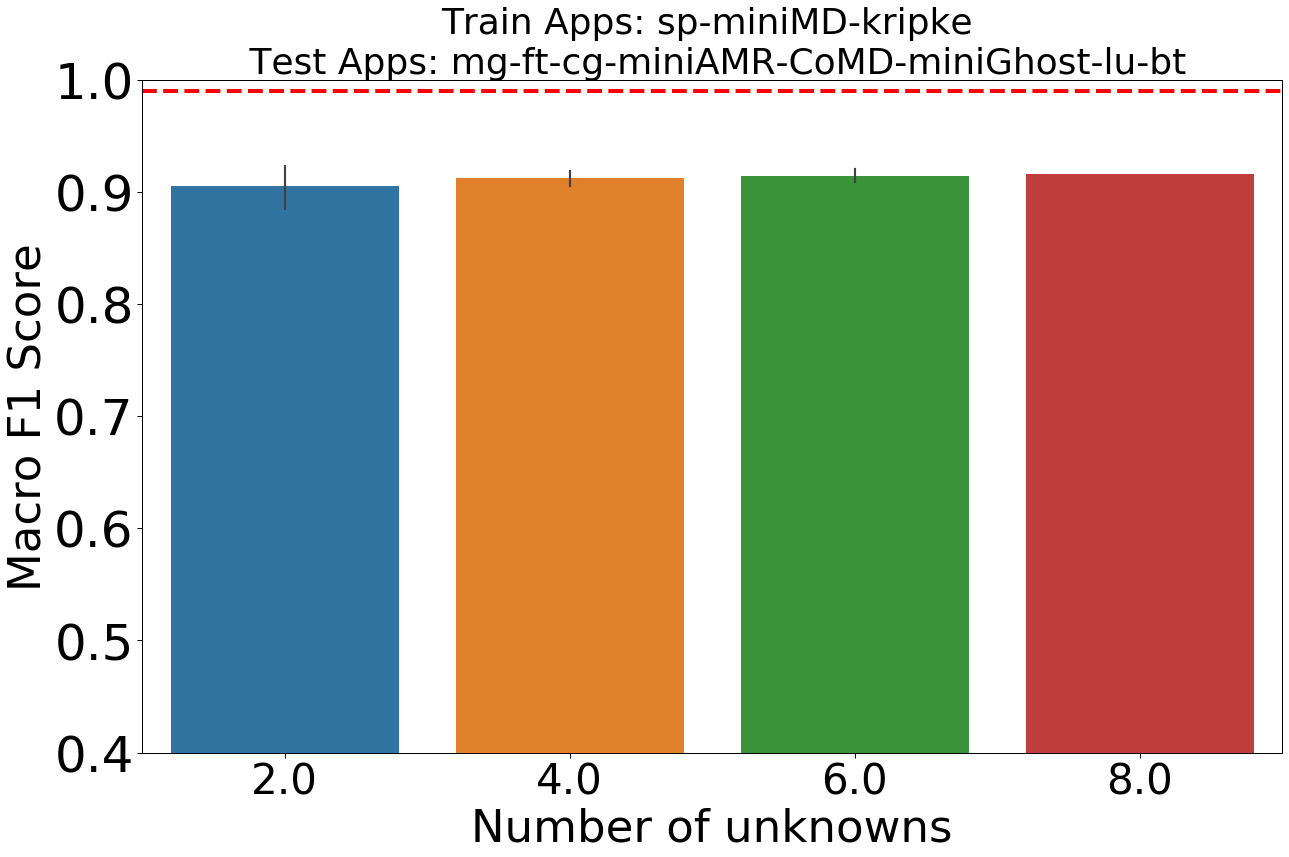

In [41]:
for app_combo in app_combos: 
    temp_result_df = result_df[result_df['train_apps'] == app_combo]
    curr_test_apps = "-".join(set(all_test_apps) - set(app_combo.split('-')))
    
    
    fig = plt.figure(figsize=(param_dict['fig_width'], param_dict['fig_height']))
    ax = sns.barplot(x="num_unknowns", 
                     y="macro_f1_score", 
                     data=temp_result_df) 
        
    ax.set_ylabel('Macro F1 Score',size=param_dict['y_label_font'])
    ax.set_xlabel(f'Number of unknowns',size=param_dict['x_label_font'])
    ax.set_title(f"Train Apps: {app_combo} \n Test Apps: {curr_test_apps}",size=param_dict['title_size'])

    plt.xticks(fontsize=param_dict['x_ticks_font'])
    plt.yticks(fontsize=param_dict['y_ticks_font'])

    plt.axhline(y=0.99,linewidth=4, color='r', linestyle='--', label='5-CV')

    ax.set(ylim=(0.4, 1))

    plt.tight_layout()            

## Plot Anomaly-wise F1-scores According to Selected App Combos 

In [54]:
selected_score = 'precision' # f1-score, precision, recall

In [55]:
param_dict = {
                'fig_width': 24,
                'fig_height': 16,
                'y_label_font': 45,
                'x_label_font': 45,
                 'x_ticks_font': 42,
                 'y_ticks_font': 50,    
                'legend_size': 26,
                'legend_title_size': 35,
                'title_size': 36,
                'title_pad': 40,             
             }

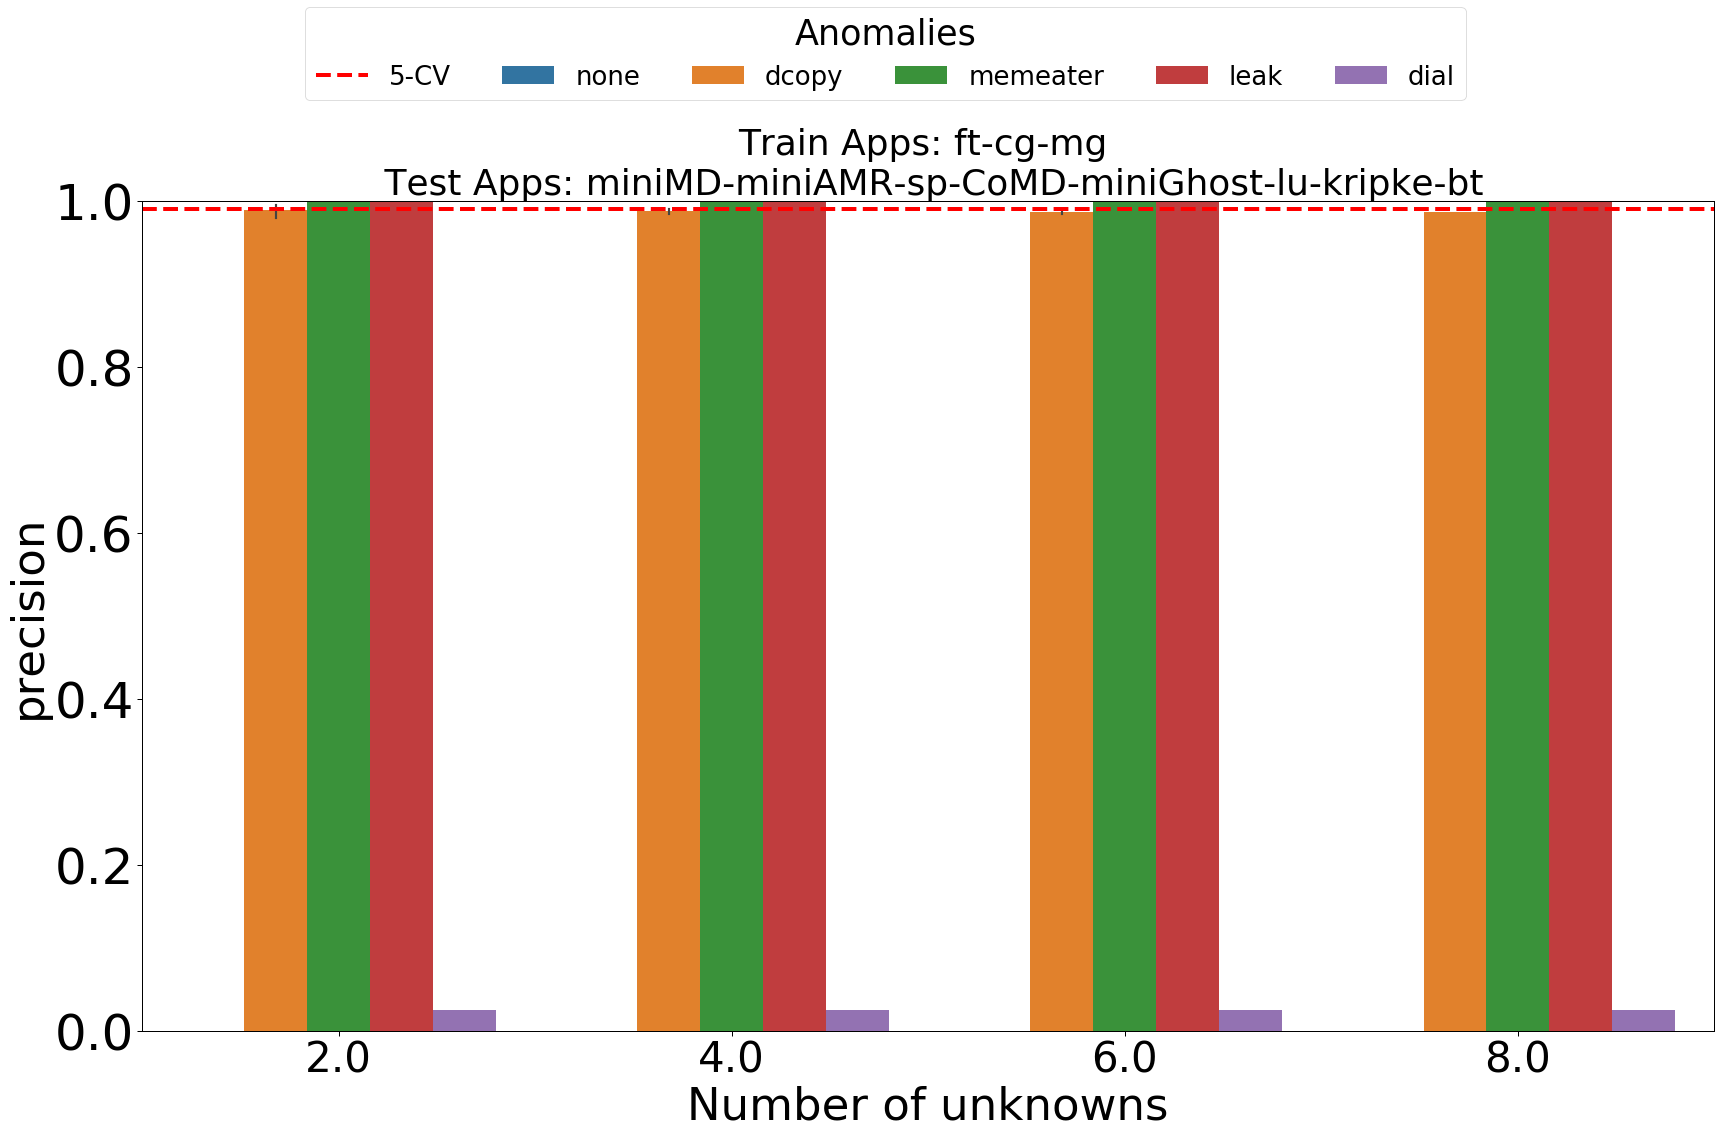

In [56]:
for app_combo in app_combos: 
    temp_result_df = result_anom_df[(result_anom_df['train_apps'] == app_combo) & (result_anom_df['score_name'] == selected_score)]
    curr_test_apps = "-".join(set(all_test_apps) - set(app_combo.split('-')))
    
    
    fig = plt.figure(figsize=(param_dict['fig_width'], param_dict['fig_height']))
    ax = sns.barplot(x="num_unknowns", 
                     y="score", 
                     hue="anom_name",
                     data=temp_result_df) 
        
    ax.set_ylabel(f'{selected_score}',size=param_dict['y_label_font'])
    ax.set_xlabel(f'Number of unknowns',size=param_dict['x_label_font'])
    ax.set_title(f"Train Apps: {app_combo} \n Test Apps: {curr_test_apps}",size=param_dict['title_size'])

    plt.xticks(fontsize=param_dict['x_ticks_font'])
    plt.yticks(fontsize=param_dict['y_ticks_font'])

    plt.axhline(y=0.99,linewidth=4, color='r', linestyle='--', label='5-CV')

    ax.set(ylim=(0, 1))
    
    legend=plt.legend(bbox_to_anchor=(0.4, 0.8, 0.45, 0.45),
               #loc='upper center', 
               ncol = 6, 
               title = "Anomalies",
               prop={'size': param_dict['legend_size']}, 
              )
    plt.setp(legend.get_title(),fontsize=param_dict['legend_title_size'])    

    plt.tight_layout()      
    
    break

In [58]:
temp_result_df[(temp_result_df['anom_name'] == 'none') & (temp_result_df['score_name'] == 'precision')]

,anom_name,cv_fold,num_unknowns,score,score_name,test_apps,train_apps
46,none,0,2.0,0.0,precision,CoMD-bt,ft-cg-mg
91,none,0,6.0,0.0,precision,kripke-CoMD-bt-miniMD-miniGhost-miniAMR,ft-cg-mg
151,none,0,4.0,0.0,precision,lu-miniMD-miniGhost-miniAMR,ft-cg-mg
241,none,0,4.0,0.0,precision,CoMD-miniMD-miniGhost-sp,ft-cg-mg
271,none,0,4.0,0.0,precision,kripke-bt-miniMD-miniGhost,ft-cg-mg
301,none,0,4.0,0.0,precision,kripke-CoMD-miniGhost-sp,ft-cg-mg
346,none,0,6.0,0.0,precision,CoMD-bt-miniMD-miniGhost-miniAMR-sp,ft-cg-mg
361,none,0,4.0,0.0,precision,kripke-CoMD-miniGhost-miniAMR,ft-cg-mg
391,none,0,2.0,0.0,precision,miniMD-miniAMR,ft-cg-mg
451,none,0,4.0,0.0,precision,kripke-CoMD-bt-miniGhost,ft-cg-mg


In [60]:
result_anom_df[(result_anom_df['anom_name']=='dial') & (result_anom_df['score_name']=='f1-score') & (result_anom_df['num_unknowns']==4)].sort_values(by=['score'])

,anom_name,cv_fold,num_unknowns,score,score_name,test_apps,train_apps
3297,dial,0,4.0,0.046029,f1-score,bt-miniMD-miniGhost-miniAMR,ft-cg-mg
1782,dial,0,4.0,0.046175,f1-score,kripke-bt-miniGhost-miniAMR,ft-cg-mg
282,dial,0,4.0,0.046217,f1-score,kripke-bt-miniMD-miniGhost,ft-cg-mg
582,dial,0,4.0,0.046300,f1-score,kripke-bt-miniMD-miniAMR,ft-cg-mg
5712,dial,0,4.0,0.046408,f1-score,kripke-miniMD-miniGhost-miniAMR,ft-cg-mg
537,dial,0,4.0,0.046974,f1-score,CoMD-bt-miniGhost-miniAMR,ft-cg-mg
2262,dial,0,4.0,0.047016,f1-score,CoMD-bt-miniMD-miniGhost,ft-cg-mg
1212,dial,0,4.0,0.047038,f1-score,lu-bt-miniGhost-miniAMR,ft-cg-mg
4737,dial,0,4.0,0.047059,f1-score,bt-miniGhost-miniAMR-sp,ft-cg-mg
4332,dial,0,4.0,0.047080,f1-score,lu-bt-miniMD-miniGhost,ft-cg-mg
